In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [2]:
# Set the number of threads for inter_op_parallelism
tf.config.threading.set_inter_op_parallelism_threads(2)


In [3]:
y_train = pd.read_csv('input/Arabic Handwritten Digits Dataset CSV/csvTrainLabel 60k x 1.csv')
X_train = pd.read_csv('input/csvTrainImages 60k x 784.csv')
y_test = pd.read_csv('input/Arabic Handwritten Digits Dataset CSV/csvTestLabel 10k x 1.csv')
X_test = pd.read_csv('input/csvTestImages 10k x 784.csv')

In [4]:
# Normalise and reshape
X_train=X_train.values.reshape((-1,28,28,1))/255.0
X_test=X_test.values.reshape((-1,28,28,1))/255.0

In [5]:
# OnehotEncode y_train
y_train=to_categorical(y_train, num_classes=10)
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [6]:
# Split into Train and validation
X_train,X_valid,y_train, y_valid = train_test_split(X_train, y_train,
                                                     test_size=0.1,
                                                     shuffle=True)
# Data Augmentation to reduce bias
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [7]:
# Early Stopping
class custom_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.92):
            self.model.stop_training=True
            
# LR Scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

def build_model():
    model = Sequential()

    # Flatten the input shape
    model.add(Flatten(input_shape=(28, 28, 1)))

    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(10, activation='softmax'))  

    return model


In [9]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model = build_model()
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [10]:
epochs=10
batch_size=64
# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_valid, y_valid),
                    verbose=2,
                    callbacks=[learning_rate_reduction])
# Save the model
model.save("ANNAdigits.h5")

Epoch 1/10
844/844 - 33s - loss: 0.5057 - accuracy: 0.8490 - val_loss: 0.0742 - val_accuracy: 0.9798 - lr: 0.0010 - 33s/epoch - 40ms/step
Epoch 2/10
844/844 - 31s - loss: 0.2090 - accuracy: 0.9431 - val_loss: 0.0517 - val_accuracy: 0.9852 - lr: 0.0010 - 31s/epoch - 37ms/step
Epoch 3/10
844/844 - 35s - loss: 0.1686 - accuracy: 0.9559 - val_loss: 0.0413 - val_accuracy: 0.9878 - lr: 0.0010 - 35s/epoch - 42ms/step
Epoch 4/10
844/844 - 31s - loss: 0.1557 - accuracy: 0.9604 - val_loss: 0.0477 - val_accuracy: 0.9858 - lr: 0.0010 - 31s/epoch - 37ms/step
Epoch 5/10
844/844 - 31s - loss: 0.1486 - accuracy: 0.9634 - val_loss: 0.0372 - val_accuracy: 0.9905 - lr: 0.0010 - 31s/epoch - 37ms/step
Epoch 6/10
844/844 - 31s - loss: 0.1511 - accuracy: 0.9644 - val_loss: 0.0373 - val_accuracy: 0.9892 - lr: 0.0010 - 31s/epoch - 37ms/step
Epoch 7/10
844/844 - 32s - loss: 0.1520 - accuracy: 0.9649 - val_loss: 0.0419 - val_accuracy: 0.9873 - lr: 0.0010 - 32s/epoch - 38ms/step
Epoch 8/10

Epoch 8: ReduceLROnPla

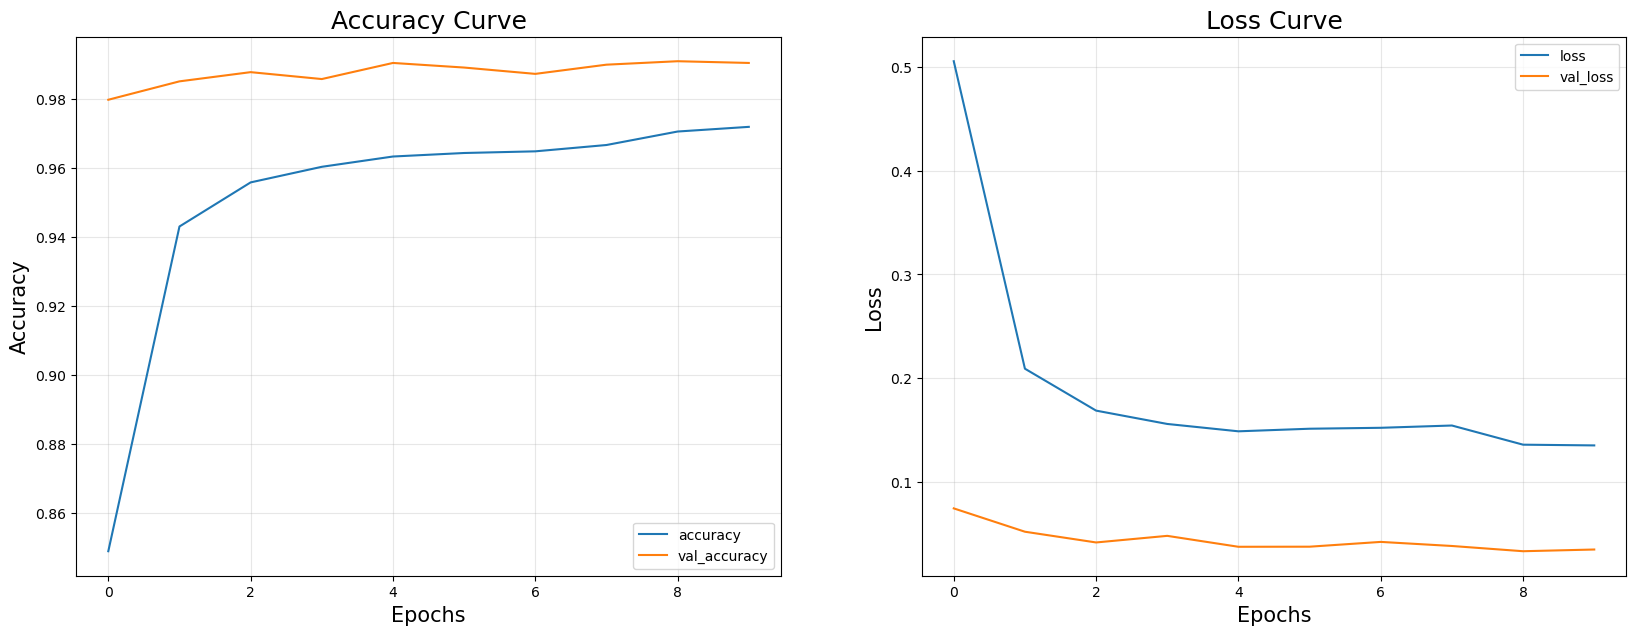

In [11]:
from matplotlib import pyplot as plt

# Diffing Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(history.epoch,history.history['accuracy'],label = "accuracy") # Accuracy curve for training set
plt.plot(history.epoch,history.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(history.epoch,history.history['loss'],label="loss") # Loss curve for training set
plt.plot(history.epoch,history.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [12]:
y_pred = model.predict(X_test)
y_test = to_categorical(y_test,num_classes=10)
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0542 - accuracy: 0.9863


[0.05421603098511696, 0.9862986207008362]

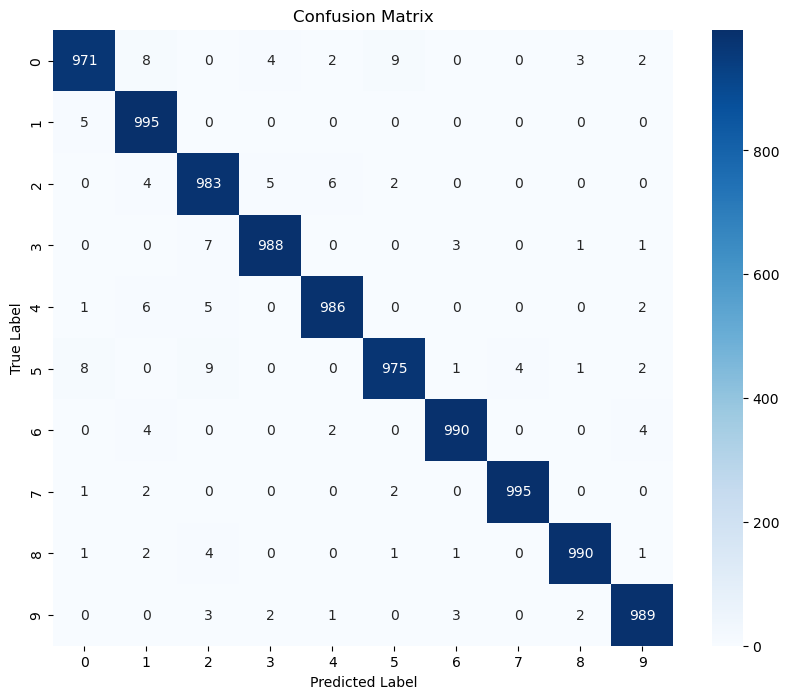

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert one-hot encoded predictions to class labels
y_pred_labels = [tf.argmax(pred).numpy() for pred in y_pred]
y_test_labels = [tf.argmax(true).numpy() for true in y_test]

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("Confusion_matrix1.png")
plt.show()
